In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from math import sqrt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

In [4]:
df = pd.read_csv("coca-cola.csv")

# Sütun isimlerini düzenleme
df.columns = ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']

# Tarih sütununu datetime formatına dönüştürme
df['date'] = pd.to_datetime(df['date'])

# Tarih sütununu indeks olarak ayarlama
df.set_index('date', inplace=True)

# Veri setinin ilk birkaç satırını ve temel bilgilerini inceleme
print(df.head())
print(df.info())

                 open       high        low      close  adj_close    volume
date                                                                       
2019-01-02  46.939999  47.220001  46.560001  46.930000  39.828789  11603700
2019-01-03  46.820000  47.369999  46.529999  46.639999  39.582672  14714400
2019-01-04  46.750000  47.570000  46.639999  47.570000  40.371952  13013700
2019-01-07  47.570000  47.750000  46.900002  46.950001  39.845768  13135500
2019-01-08  47.250000  47.570000  47.040001  47.480000  40.295567  15420700
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-01-02 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       1258 non-null   float64
 1   high       1258 non-null   float64
 2   low        1258 non-null   float64
 3   close      1258 non-null   float64
 4   adj_close  1258 non-null   float64
 5   volume     1258 non-null   int64  
dtypes: float64(5), int6

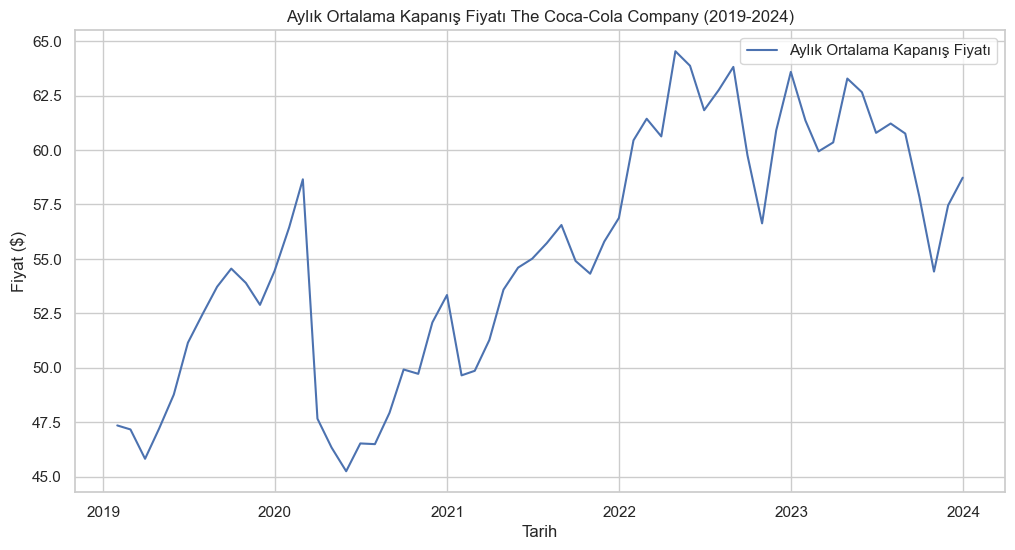

In [6]:
df_monthly = df.resample('M').mean()

plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly['close'], label='Aylık Ortalama Kapanış Fiyatı')
plt.xlabel('Tarih')
plt.ylabel('Fiyat ($)')
plt.legend()
plt.title('Aylık Ortalama Kapanış Fiyatı The Coca-Cola Company (2019-2024)')
plt.show()

In [42]:
def create_lag_features(df, target_col, lags):
    for lag in range(1, lags + 1):
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    return df

lags = 5
df = create_lag_features(df, 'close', lags)

df.dropna(inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_close'] = scaler.fit_transform(df['close'].values.reshape(-1, 1))

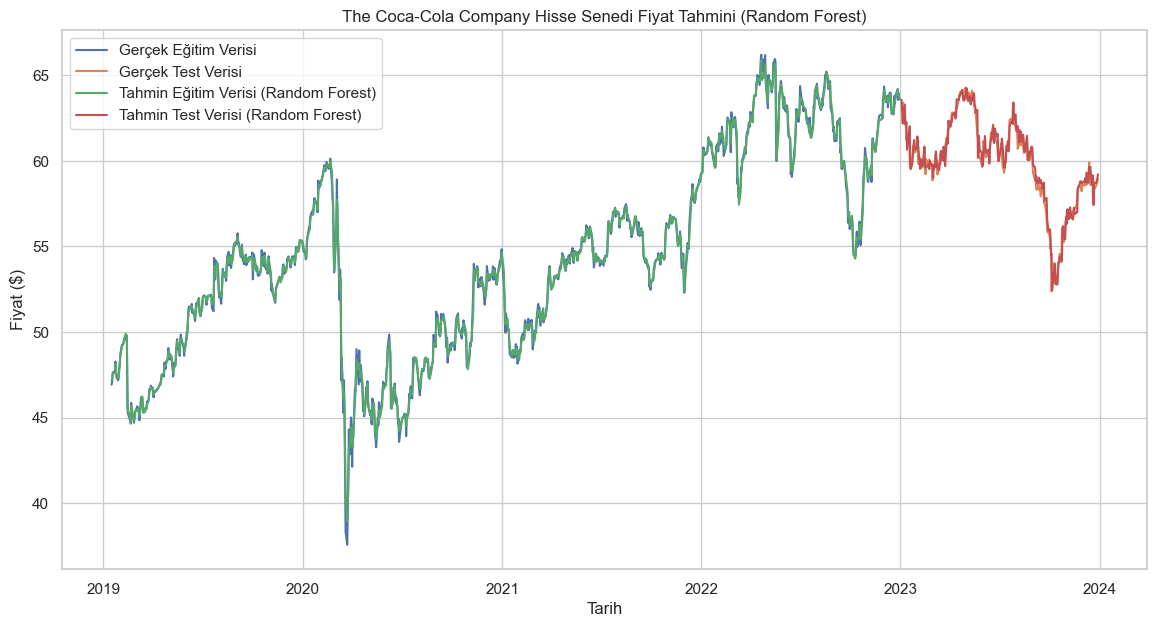

In [43]:
# Eğitim ve test verilerini bölme
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Özellik ve hedef değerlerin ayrılması
features = [f'close_lag_{i}' for i in range(1, lags + 1)]
X_train = train[features].values
y_train = train['scaled_close'].values

X_test = test[features].values
y_test = test['scaled_close'].values

# RandomForest Model
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

plt.figure(figsize=(14, 7))
plt.plot(df.index[:train_size], scaler.inverse_transform(y_train.reshape(-1, 1)), label='Gerçek Eğitim Verisi')
plt.plot(df.index[train_size:], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Gerçek Test Verisi')
plt.plot(df.index[:train_size], scaler.inverse_transform(y_pred_train_rf.reshape(-1, 1)), label='Tahmin Eğitim Verisi (Random Forest)')
plt.plot(df.index[train_size:], scaler.inverse_transform(y_pred_test_rf.reshape(-1, 1)), label='Tahmin Test Verisi (Random Forest)')
plt.xlabel('Tarih')
plt.ylabel('Fiyat ($)')
plt.legend()
plt.title('The Coca-Cola Company Hisse Senedi Fiyat Tahmini (Random Forest)')
plt.show()

In [22]:
mse_rf = mean_squared_error(y_test, y_pred_test_rf)
rmse_rf = sqrt(mse_rf)
print(f"Test Verisi İçin MSE (Random Forest): {mse_rf}, RMSE (Random Forest): {rmse_rf}")

Test Verisi İçin MSE (Random Forest): 0.00040297954922778, RMSE (Random Forest): 0.020074350530659268


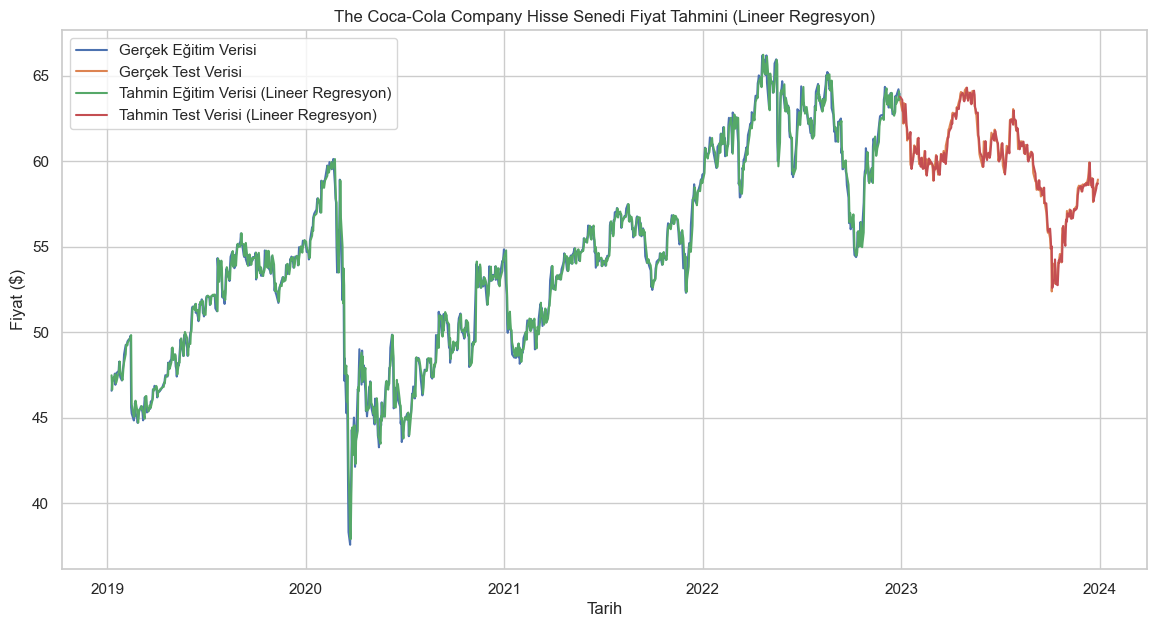

Test Verisi İçin MSE (Lineer Regresyon): 0.00030133495688336876, RMSE (Lineer Regresyon): 0.017359002185706664


In [33]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_train_lr = lr_model.predict(X_train)
y_pred_test_lr = lr_model.predict(X_test)

plt.figure(figsize=(14, 7))
plt.plot(df.index[:train_size], scaler.inverse_transform(y_train.reshape(-1, 1)), label='Gerçek Eğitim Verisi')
plt.plot(df.index[train_size:], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Gerçek Test Verisi')
plt.plot(df.index[:train_size], scaler.inverse_transform(y_pred_train_lr.reshape(-1, 1)), label='Tahmin Eğitim Verisi (Lineer Regresyon)')
plt.plot(df.index[train_size:], scaler.inverse_transform(y_pred_test_lr.reshape(-1, 1)), label='Tahmin Test Verisi (Lineer Regresyon)')
plt.xlabel('Tarih')
plt.ylabel('Fiyat ($)')
plt.legend()
plt.title('The Coca-Cola Company Hisse Senedi Fiyat Tahmini (Lineer Regresyon)')
plt.show()

mse_lr = mean_squared_error(y_test, y_pred_test_lr)
rmse_lr = sqrt(mse_lr)
print(f"Test Verisi İçin MSE (Lineer Regresyon): {mse_lr}, RMSE (Lineer Regresyon): {rmse_lr}")

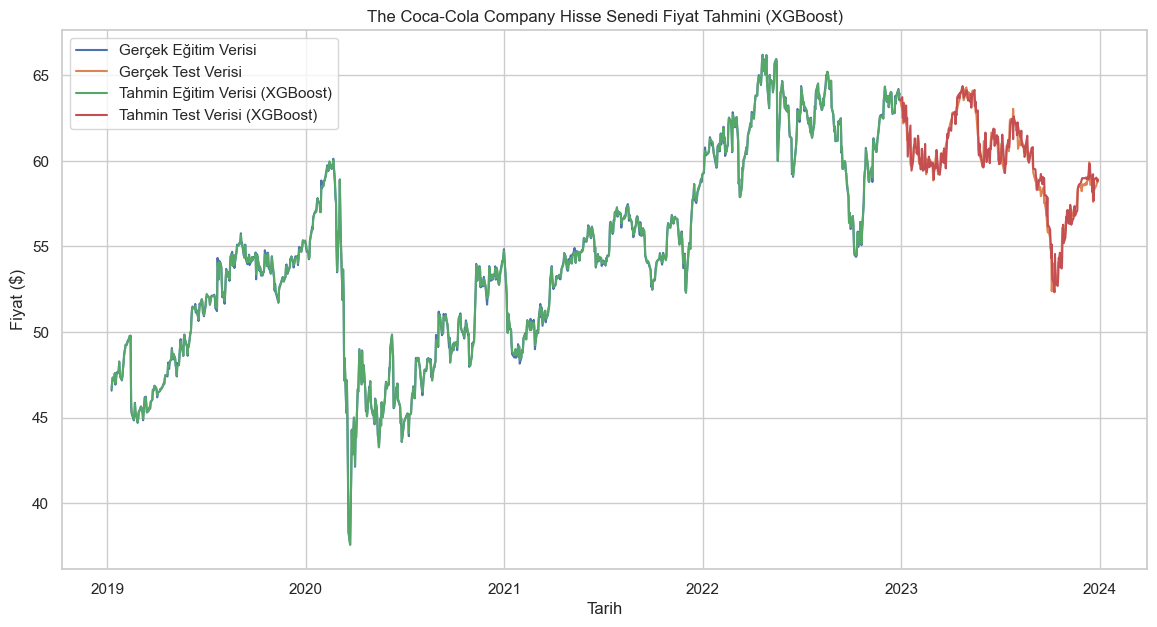

Test Verisi İçin MSE (XGBoost): 0.000485956277861208, RMSE (XGBoost): 0.02204441602449945


In [34]:
# XGBoost Model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_test_xgb = xgb_model.predict(X_test)

plt.figure(figsize=(14, 7))
plt.plot(df.index[:train_size], scaler.inverse_transform(y_train.reshape(-1, 1)), label='Gerçek Eğitim Verisi')
plt.plot(df.index[train_size:], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Gerçek Test Verisi')
plt.plot(df.index[:train_size], scaler.inverse_transform(y_pred_train_xgb.reshape(-1, 1)), label='Tahmin Eğitim Verisi (XGBoost)')
plt.plot(df.index[train_size:], scaler.inverse_transform(y_pred_test_xgb.reshape(-1, 1)), label='Tahmin Test Verisi (XGBoost)')
plt.xlabel('Tarih')
plt.ylabel('Fiyat ($)')
plt.legend()
plt.title('The Coca-Cola Company Hisse Senedi Fiyat Tahmini (XGBoost)')
plt.show()

mse_xgb = mean_squared_error(y_test, y_pred_test_xgb)
rmse_xgb = sqrt(mse_xgb)
print(f"Test Verisi İçin MSE (XGBoost): {mse_xgb}, RMSE (XGBoost): {rmse_xgb}")

In [48]:
def create_lstm_data(data, lags):
    X, y = [], []
    for i in range(len(data) - lags):
        X.append(data[i:i + lags])
        y.append(data[i + lags])
    return np.array(X), np.array(y)

scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_close'] = scaler.fit_transform(df['close'].values.reshape(-1, 1))

train_size = int(len(df) * 0.8)
lags = 60

X_train_lstm, y_train_lstm = create_lstm_data(df['scaled_close'].values[:train_size], lags)
X_test_lstm, y_test_lstm = create_lstm_data(df['scaled_close'].values[train_size:], lags)

X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1388
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0124
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0086
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0075
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0077
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0069
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0071
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0063
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0062
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0072
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0065
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0053
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0056
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0053
Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0049
Epoc

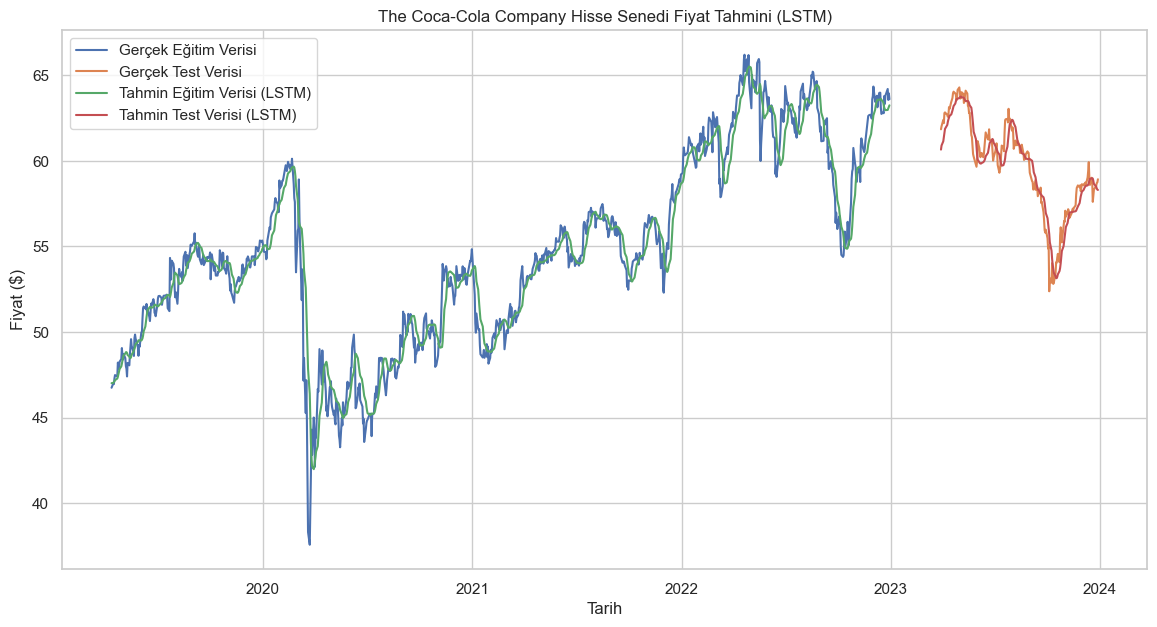

In [50]:
# LSTM Model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(lags, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, verbose=1)

y_pred_train_lstm = lstm_model.predict(X_train_lstm)
y_pred_test_lstm = lstm_model.predict(X_test_lstm)

plt.figure(figsize=(14, 7))
plt.plot(df.index[lags:train_size], scaler.inverse_transform(y_train_lstm.reshape(-1, 1)), label='Gerçek Eğitim Verisi')
plt.plot(df.index[train_size + lags:], scaler.inverse_transform(y_test_lstm.reshape(-1, 1)), label='Gerçek Test Verisi')
plt.plot(df.index[lags:train_size], scaler.inverse_transform(y_pred_train_lstm.reshape(-1, 1)), label='Tahmin Eğitim Verisi (LSTM)')
plt.plot(df.index[train_size + lags:], scaler.inverse_transform(y_pred_test_lstm.reshape(-1, 1)), label='Tahmin Test Verisi (LSTM)')
plt.xlabel('Tarih')
plt.ylabel('Fiyat ($)')
plt.legend()
plt.title('The Coca-Cola Company Hisse Senedi Fiyat Tahmini (LSTM)')
plt.show()

In [51]:
mse_lstm = mean_squared_error(y_test_lstm, y_pred_test_lstm)
rmse_lstm = sqrt(mse_lstm)
print(f"Test Verisi İçin MSE (LSTM): {mse_lstm}, RMSE (LSTM): {rmse_lstm}")

Test Verisi İçin MSE (LSTM): 0.0009333144882205964, RMSE (LSTM): 0.030550196205926344
